# Predicting Depression in Reddit Posts with NLP

##### Author: Spencer Hadel
***
##### _________________ pitch

## The Problem
***
## The Data
***
## Methods
***
## Results
***
## Conclusion


***
***


remember to include detailed info in into, conclusion, readme about all models and methods used
##### __________________________________________________________________________________

In [1]:

# ##### Author: Spencer Hadel
# ***
# ### Overview

# According to the World Health Organization, pneumonia accounts for 14% of all deaths of children under 5 years old. Also according to the WHO, pneumonia can be prevented but only one third of children who have it receive the antibiotics they need. More information [can be found here](https://www.who.int/news-room/fact-sheets/detail/pneumonia).

# A new artificial intelligence based medical research company, **Medecins Sans Limites (MSL)**, has launched a number of initiatives to create Neural Networks which aid the globe in solving crises like this one. The current project aims to accurately predict pneumonia based on chest radiography. 

# The diagnosis of pneumonia requires a highly trained medical professional, as well as a variety of lab tests and a deep analysis of the patient's medical history and other symptoms. *MSL* does not aim to replace every step of the medical diagnosis process, as the human element of understanding other facts about a patient still remain. The objective is to create a highly accurate and sensitive model that can help medical professionals identify cases they need to treat based on the x-rays. 

# This will be particularly useful in developing nations and parts of the world where circumstances inhibit access trained medical staff or equipment. If successful, it also stands to aid areas with full access to medical care, either providing a second opinion or helping confirm medical diagnoses.
# ***

# ## Data

# The [data for this project is from this source on kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia), and states the following: 

# "Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care."

# The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

# According to the source of the data:

# *"all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert."* 

# The Data consists of __5,863 Chest X-Rays of patients 1-5 years old__. This consists of __1583 x-rays of patients labeled 'NORMAL', and 4,280 x-rays of patients labeled 'PNEUMONIA'.__ Throughout this project, the data will be used to create __training, validation, and test datasets__ in order to build models that can predict outcomes.

# The first step this analysis takes is to create image data generators, which create useable train, test, and validation datasets. Each of these datasets contained 2 classes, **0 and 1** denoting whether the image showed a case labeled as **NORMAL or PNEUMONIA**, respectively.

# Some samples of what NORMAL and PNEUMONIA images look like are below (taken from the validation set of data):

# img img img

# ## Methods

# This project creates multiple **Convolutional Neural Networks** in order to create a high performing **Binary Classification Model** for identifying patients with and without pneumonia.

# An important thing to observe in each model is the performance throughout epochs, particularly the *Accuracy and Loss* of both the *Training and Validation* data throughout the training process of each model.

# We also use *Confusion Marices* to show each model's predictions on the test data for each iteration of the project. This shows how many times a given model makes each prediction (0 or 1, since this is a binary classification problem), and whether that prediction matches the actual label of the image.

# Additionally, we use certain metrics to identify how effective each model was when making predicitons on the test data, iterating on each successful outcome.

# > * Binary Accuracy: Accuracy is of course, important. It will tell us how well our model successfully predicts cases of pneumonia. Ideally, we will always want our accuracy score to go up. Without an accurate model, there is no valuable outcome for this analysis. Binary accuracy is a built in keras metric used specifically for binary classification problems like this one.
# > * Loss: The Loss of each model can be observed in the model.fit phase of the analysis. This metric will be a rough understanding of how our model is performing. Ideally, loss will get smaller throughout training epochs as well as throughout the iterative modeling process.

# One method in particular was the *Data Augmentation* on the training data, which alters the images to train our model on more general features of the data instead of overfitting on specifics that would be harmful to its performance. An example of these augmented images can be seen below:
# ![](./img/0-augmented_img_example.png)

# Another important method was the *Dropout Regularization* step that was taken to train the model more generally once more. This process literally makes the model "drop out" some of the trained neurons.

***
***

# EDA and Preprocessing

In [2]:
#imports
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
import re
import string
import seaborn as sns
import nltk
import cv2
import gensim
from scipy import spatial
from nltk import word_tokenize, FreqDist
from nltk.collocations import *
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from gensim.models import Word2Vec, word2vec
from mpl_toolkits.axes_grid1 import ImageGrid
from wordcloud import WordCloud

#models:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

import tensorflow as tf
from keras.optimizers import SGD
from tensorflow.keras import preprocessing
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

from keras_preprocessing.sequence import pad_sequences


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#seed for reproducible results
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
#load data:

data_dir_depression = './data/depression_dataset_reddit_cleaned.csv'
df = pd.read_csv(data_dir_depression)

## Exploratory Data Analysis

##### ______________________________________ link to here from top

We start by checking the data for any null values, or incosistent data that may throw off future modeling.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7731 entries, 0 to 7730
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_text     7731 non-null   object
 1   is_depression  7731 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 120.9+ KB


In [5]:
df.head()

,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1


In [6]:
df.isna().sum()

clean_text       0
is_depression    0
dtype: int64

In [7]:
df['is_depression'].value_counts()

0    3900
1    3831
Name: is_depression, dtype: int64

__Fortunately, the data was pre-cleaned__, which in this instance means taht there are no missing values, and as an added bonus the classes are __almost perfectly balanced__.

## Preprocessing Data

The next step is to create a variety of new columns in our DataFrame for each type of transformation we can apply to the existing 'clean_text' dataset. The reason for this is that we will then __have the freedom to test models on different levels of preprocessed data__, which is important in order to identify what the best option is in NLP.

### Lowercase Text

The first thing to do is check that all of our text is lowercase, so that our models don't train the same word with different capitalization as multiple features.

In this case, the text data from the downloaded dataset is already lowercase, so we do not need to take this step!

In [8]:
df['islowercase'] = list(map(lambda x: x.islower(), df['clean_text']))
df['islowercase'].value_counts()

True    7731
Name: islowercase, dtype: int64

In [9]:
# df['lower_text'] = df['clean_text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
# df['lower_text'].head()

### Tokenize
Next, we __tokenize the data__, meaning we separate each entry (in the format of a string of words) into a list of individual _tokens_. This is so that our future models will interpret each word as its own feature influencing the outcome.

The RegEx code is implemented to make sure that words with apostrophes are tokenized as individual words, instead of the apostrophe separating the word into two half words.

In [10]:
def tokenize_data(data):
    
    #(this regex code keeps words with apostrophes as single tokens)
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    
    #create tokens
    tokens = nltk.regexp_tokenize(data, pattern)
    return [word for word in tokens]

In [11]:
df['tokenized'] = df.apply(lambda x: tokenize_data(x['clean_text']), axis=1)

#make sure that each row now displays tokenized data
df['tokenized'].head()

0    [we, understand, that, most, people, who, repl...
1    [welcome, to, r, depression, s, check, in, pos...
2    [anyone, else, instead, of, sleeping, more, wh...
3    [i, ve, kind, of, stuffed, around, a, lot, in,...
4    [sleep, is, my, greatest, and, most, comfortin...
Name: tokenized, dtype: object

### Stopwords
_Stopwords_ are words in a language that are predominantly filler words, like the words __the, a, and__, etc. These words are generally considered not to hold much value in NLP, but there are instances where they can be valuable. This is why we will create a _new_ column in our dataset, so that we have access to the data _with_ and _without_ stopwords.

If we show the most common words in our dataset as it is now, we will predominantly if not entirely see these words.


In [12]:
#show top FreqDist of Tokenized Column
FreqDist(sum(df['tokenized'], [])).most_common(30)

[('i', 40411),
 ('to', 17965),
 ('and', 16326),
 ('a', 12638),
 ('the', 11932),
 ('my', 11430),
 ('it', 9976),
 ('of', 7738),
 ('t', 7698),
 ('me', 6941),
 ('that', 6506),
 ('in', 6088),
 ('m', 5758),
 ('but', 5427),
 ('is', 5324),
 ('for', 5196),
 ('have', 5007),
 ('this', 4557),
 ('just', 4527),
 ('so', 4337),
 ('s', 4073),
 ('with', 3869),
 ('wa', 3810),
 ('like', 3584),
 ('not', 3275),
 ('feel', 3227),
 ('can', 3217),
 ('be', 3158),
 ('on', 3075),
 ('don', 3029)]

In [13]:
stops = stopwords.words('english')

#add punctuation
for symbol in ",.'?!()":
    stops += symbol

    #show example of stopwords list
print(stops)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Above is the full list of stopwords, plus some common symbols found in written english. The cleaned dataset was mostly devoid of these symbols anyway, but it doesn't hurt to add them to our list of stopwords to remove.

In [14]:
def tokenize_remove_stops(data):
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokens = nltk.regexp_tokenize(data, pattern)
    return [word for word in tokens if word not in stops]

In [15]:
#remove stopwords for a new column in the dataframe:
df['tokenized_no_stops'] = df.apply(lambda x: tokenize_remove_stops(x['clean_text']), axis=1)

#show difference
df[['tokenized','tokenized_no_stops']].head()

,tokenized,tokenized_no_stops
0,"[we, understand, that, most, people, who, repl...","[understand, people, reply, immediately, op, i..."
1,"[welcome, to, r, depression, s, check, in, pos...","[welcome, r, depression, check, post, place, t..."
2,"[anyone, else, instead, of, sleeping, more, wh...","[anyone, else, instead, sleeping, depressed, s..."
3,"[i, ve, kind, of, stuffed, around, a, lot, in,...","[kind, stuffed, around, lot, life, delaying, i..."
4,"[sleep, is, my, greatest, and, most, comfortin...","[sleep, greatest, comforting, escape, whenever..."


There is a clear difference between our data _with_ and _without_ stopwords, just from the first few rows of the dataframe.

In [16]:
#show top FreqDist now that stopwords are removed!
freq_minus_stops = FreqDist(sum(df['tokenized_no_stops'], []))
freq_minus_stops.most_common(20)

[('wa', 3810),
 ('like', 3584),
 ('feel', 3227),
 ('get', 2316),
 ('want', 2292),
 ('know', 2283),
 ('life', 2147),
 ('time', 2069),
 ('even', 1812),
 ('day', 1688),
 ('people', 1660),
 ('really', 1617),
 ('depression', 1569),
 ('anxiety', 1548),
 ('thing', 1534),
 ('one', 1522),
 ('year', 1438),
 ('go', 1398),
 ('friend', 1297),
 ('would', 1285)]

__Now that the stopwords have been removed__, we can see that the most prominent word is, confusingly enough, "wa". A quick look at the data makes it clear that this is the result of reddit users mistyping the word "was" (which raises the delightful question of why redditors can't seem to type that word right), so we just remove it too!

In [17]:
stops.extend(['wa'])
df['tokenized_no_stops'] = df.apply(lambda x: tokenize_remove_stops(x['clean_text']), axis=1)

freq_minus_stops = FreqDist(sum(df['tokenized_no_stops'], []))
freq_minus_stops.most_common(20)

[('like', 3584),
 ('feel', 3227),
 ('get', 2316),
 ('want', 2292),
 ('know', 2283),
 ('life', 2147),
 ('time', 2069),
 ('even', 1812),
 ('day', 1688),
 ('people', 1660),
 ('really', 1617),
 ('depression', 1569),
 ('anxiety', 1548),
 ('thing', 1534),
 ('one', 1522),
 ('year', 1438),
 ('go', 1398),
 ('friend', 1297),
 ('would', 1285),
 ('think', 1280)]

With stopwords removed, we start to get a better picture of some prominent words. In paricular, there are __a little over 1500 occurences of 'depression' and 'anxiety'__, which we will dig into further in a bit. 

### Lemmatization
To _lemmatize_ a word is to reduce it to its root word, usually removing any 'ed's or 'ing's from the ending.

In [18]:
lemmatizer = WordNetLemmatizer()

def lemmatize_data(data):
    return [lemmatizer.lemmatize(word) for word in data]

In [19]:
df['lemmatized_no_stops'] = df['tokenized_no_stops'].apply(lemmatize_data)
df['lemmatized_no_stops'].head()

0    [understand, people, reply, immediately, op, i...
1    [welcome, r, depression, check, post, place, t...
2    [anyone, else, instead, sleeping, depressed, s...
3    [kind, stuffed, around, lot, life, delaying, i...
4    [sleep, greatest, comforting, escape, whenever...
Name: lemmatized_no_stops, dtype: object

#### Rejoining Words
Finally, we have to _rejoin_ the tokenized words back into strings of text, instead of individual word tokens. This is an important step so we ca pass the correct format of data through a _Vectorizer_.

In [20]:
def rejoin_words(column):
    return ( " ".join(column))

df['rejoined']= df.apply(lambda x: rejoin_words(x['lemmatized_no_stops']), axis=1)
df['rejoined']

0       understand people reply immediately op invitat...
1       welcome r depression check post place take mom...
2       anyone else instead sleeping depressed stay ni...
3       kind stuffed around lot life delaying inevitab...
4       sleep greatest comforting escape whenever wake...
                              ...                        
7726                                                 snow
7727                                 moulin rouge mad cry
7728                        trying shout find people list
7729    ughh find red sox hat got ta wear creepy nick ...
7730    slept wonderfully finally tried swatching new ...
Name: rejoined, Length: 7731, dtype: object

### The Peprocessed Dataset
Here we can see some of the major alterations we made to the the data, side by side.

In [21]:
#show df minus the columns we dont need for this analysis
df[['clean_text','tokenized', 'lemmatized_no_stops', 'rejoined']].head()

,clean_text,tokenized,lemmatized_no_stops,rejoined
0,we understand that most people who reply immed...,"[we, understand, that, most, people, who, repl...","[understand, people, reply, immediately, op, i...",understand people reply immediately op invitat...
1,welcome to r depression s check in post a plac...,"[welcome, to, r, depression, s, check, in, pos...","[welcome, r, depression, check, post, place, t...",welcome r depression check post place take mom...
2,anyone else instead of sleeping more when depr...,"[anyone, else, instead, of, sleeping, more, wh...","[anyone, else, instead, sleeping, depressed, s...",anyone else instead sleeping depressed stay ni...
3,i ve kind of stuffed around a lot in my life d...,"[i, ve, kind, of, stuffed, around, a, lot, in,...","[kind, stuffed, around, lot, life, delaying, i...",kind stuffed around lot life delaying inevitab...
4,sleep is my greatest and most comforting escap...,"[sleep, is, my, greatest, and, most, comfortin...","[sleep, greatest, comforting, escape, whenever...",sleep greatest comforting escape whenever wake...


#### Check for Significant Words in Corpus

Now we'll look through the data to attempt to identify any notable patterns identifying each class (_is_depression=1_ and _is_depression=0_) 

In [22]:
depressed_df = df[df['is_depression']==1]
undiag_df = df[df['is_depression']==0]

depressed_top = FreqDist(sum(depressed_df['lemmatized_no_stops'], [])).most_common(50)
undiag_top = FreqDist(sum(undiag_df['lemmatized_no_stops'], [])).most_common(50)

depressed_top = pd.Series(dict(depressed_top))
undiag_top = pd.Series(dict(undiag_top))

In [23]:
depressed_top

like          3398
feel          3115
know          2153
want          2135
life          2109
get           2084
time          1908
even          1751
people        1603
depression    1569
anxiety       1545
really        1480
thing         1460
day           1447
year          1395
one           1373
friend        1249
would         1224
go            1183
think         1180
make          1132
ha            1087
going         1083
never         1067
much          1018
help           985
back           882
thought        881
feeling        878
work           823
im             814
way            792
anything       786
always         765
everything     765
anyone         762
still          747
something      741
got            732
every          703
bad            702
anymore        701
also           697
better         690
see            690
good           689
could          684
need           667
someone        646
nothing        639
dtype: int64

In [24]:
undiag_top

work        270
day         241
get         232
go          215
today       192
like        186
got         183
sleep       179
going       169
back        167
time        162
want        157
ha          156
need        151
still       150
one         149
quot        145
sad         138
really      137
good        130
know        130
http        126
im          125
miss        118
u           118
oh          114
much        113
night       113
feel        112
com         109
morning     109
lol         107
sorry       103
think       100
na          100
bad         100
twitter      99
last         96
well         95
amp          94
see          92
home         92
hate         88
sick         87
love         84
hope         83
tomorrow     82
new          82
bed          82
wish         81
dtype: int64

Above are the most common words in each class, by Frequency Distribution. Below we can see what the most common words in the depressed class that _are not_ in the most common words of the undiagnosed 
class. This can give us an insight into what kinds of words are being used that are __unique to the depressed class__.

In [25]:
depressed_unique=depressed_top

for x in depressed_unique.index:
    if x in undiag_top.index:
        depressed_unique.pop(x)
        
depressed_unique

life          2109
even          1751
people        1603
depression    1569
anxiety       1545
thing         1460
year          1395
friend        1249
would         1224
make          1132
never         1067
help           985
thought        881
feeling        878
way            792
anything       786
always         765
everything     765
anyone         762
something      741
every          703
anymore        701
also           697
better         690
could          684
someone        646
nothing        639
dtype: int64

Below is a __visualization__, to better understand the most common words unique to _is_depression=1_.

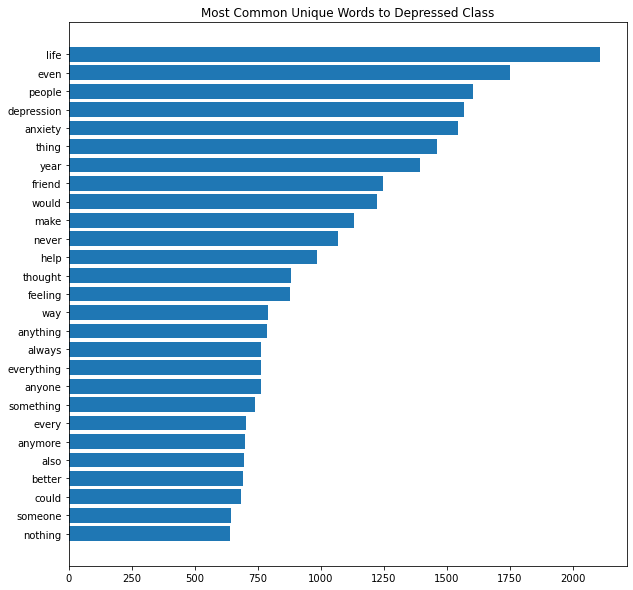

<Figure size 432x288 with 0 Axes>

In [26]:
fig = plt.figure(figsize =(10, 10))
plt.gca().invert_yaxis()
plt.barh(depressed_unique.index, depressed_unique.values)
plt.title('Most Common Unique Words to Depressed Class')
# Show Plot
plt.show()

figname='commonDepressedWords'
plt.savefig('./img/'+figname+'.png')

And next, for artsy points, some word clouds showing the prominent tokens in each class. __Depressed first:__

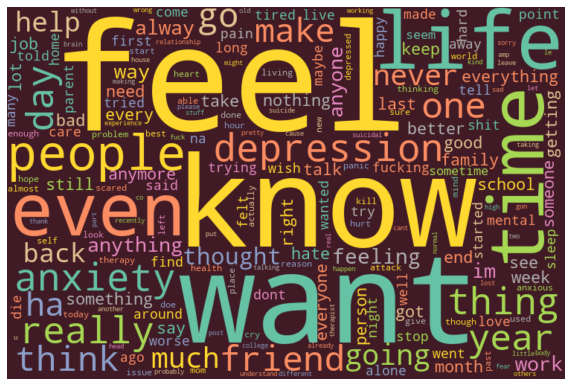

In [27]:
#word cloud:
rejoined = depressed_df.apply(lambda x: rejoin_words(x['tokenized_no_stops']), axis=1)
words = ' '.join([content for content in rejoined])

wordcloud = WordCloud(width=750, height=500, random_state=42, max_font_size=200, background_color='#401a24', colormap='Set2', collocations=False).generate(words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

imgName= 'cloud-Depression'
wordcloud.to_file('./img/'+imgName+'.png')

And then __Undiagnosed:__

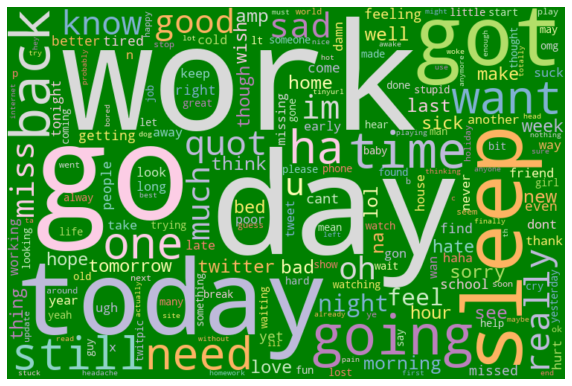

In [28]:
#word cloud:
rejoined = undiag_df.apply(lambda x: rejoin_words(x['tokenized_no_stops']), axis=1)
words = ' '.join([content for content in rejoined])

wordcloud = WordCloud(width=750, height=500, random_state=42, max_font_size=200, background_color='green', colormap='Set3', collocations=False).generate(words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

imgName= 'cloud-Undiag'
wordcloud.to_file('./img/'+imgName+'.png')

Visualizations are all well and good, but only give us a basic human-brained understanding of what makes up each class. Next we will run the preprocessed data through multiple __Machine Learning Models__ to identify more complex patterns.

# Modeling

For our initial modeling, we will use the un-altered _df['clean_text']_. After testing our baseline model with that data, we will use our preprocessed dataset and compare results.

### Splitting Data

In [29]:
#train_test_split data

X = df['clean_text']
y = df['is_depression']

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### Implementing a Vectorizer

For this analysis, we will be using a __tf-idf Vectorizer__. _Vectorizing_ is the process of converting text into numerical data interpretable by the machine learning model.

_Tf-idf_ indicates that each word will be given numerical weight based on _term frequency_ and _inverse document frequency_. The higher the tf-idf value, the more "important" a word is within the corpus.

The current tf-idf 'max_features' has been set at 100, to limit the data when modeling to the 100 highest scoring features.

In [30]:
#max features 100 as a starting point
vectorizer = TfidfVectorizer(max_features=100)

X_train_vectorized = vectorizer.fit_transform(X_train)

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=vectorizer.get_feature_names())

,about,all,always,am,an,and,anxiety,any,anyone,are,...,we,what,when,who,will,with,work,would,year,you
0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.538367,0.000000,0.451680,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
2,0.188074,0.035935,0.049669,0.0,0.0,0.314132,0.042052,0.179436,0.000000,0.0,...,0.000000,0.075859,0.080886,0.047301,0.0,0.065732,0.0,0.044510,0.086666,0.036945
3,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.0,0.0,0.188034,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.346354,0.000000,0.287489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6179,0.000000,0.087283,0.000000,0.0,0.0,0.176076,0.000000,0.000000,0.000000,0.0,...,0.000000,0.092127,0.000000,0.000000,0.0,0.159657,0.0,0.000000,0.000000,0.000000
6180,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
6181,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.838652
6182,0.000000,0.000000,0.000000,0.0,0.0,0.242542,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000


### Metrics and Scoring

The four primary metrics we will display with each model are:

 >Accuracy: Accuracy is of course, important. It indidicates how successfully our model _predicts correct values_ of the two classes (is_depression = 1 and is_depression = 0, in this case).
 
 >Recall: Recall is a models ability to _avoid predicting False Negatives_, or in this case, to _avoid misidentifying a class as depression=0_ when it in fact is labeled as is_depression=1.
 
 >Precision: Precision indicates the model's strength in _avoiding prediction of False Positives_, or in this case to prevent "misdiagnosing" a post as indicating depression when in fact it does not.
 
 >F1: F1 Score is the _harmonic mean_ between Precision and Recall Scores, meaning that a high F1 score means the model isn't accidentally sacrificing Recall for Precision, or vice versa.
 
For the purposes of this analysis, the primary scores to take into account will be the __Accuracy and Recall scores__. The reason we want to __raise Accuracy while also keeping Recall high__ is that we want our models to be _accurate without accidentally misdiagnosing an individual as well when they in fact could benefit from a diagnosis of depression_.

In [31]:
#create score df
score_df = pd.DataFrame(columns = ['Name','Accuracy', 'Recall', 'Precision', 'F1'])

In [32]:
def update_score_df(name):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 =f1_score(y_test, y_pred)
    
    #create new df entry
    entry = {'Name': name, 'Accuracy': acc, 'Recall': recall, 'Precision': prec, 'F1':f1}
    #print('adding: ',entry)
    return entry

## Baseline Model - MultinomialNB
The _Multinomial Naive Bayes_ classifier is a go-to standard classification model in the the Machine Learning Field. We will run the data through this with all of its default settings.

In [33]:
#model name for score keeping
model_name = 'Baseline - MultiNB'

nb_model = MultinomialNB()

baseline_cv = cross_val_score(nb_model, X_train_vectorized, y_train)
baseline_cv

array([0.8367017 , 0.82053355, 0.82295877, 0.82700081, 0.82281553])

### A Note on the Understanding of Scoring

The __cross-validation score__ shown above indicates that already (over 5 cross validation folds), our model is performing pretty strongly on the train data. With the classes split almost perfectly evenly, a score of 82% accuracy is extremely good.

__However__, there are also several features in this dataset that could be giving our model an __unfair advantage__ as far as the goals of this analysis are concerned. Shortly, we will dig deeper into the cause of this. Next, however, we will see how well the model performs when predicting values on the test data:

### Evaluate Model on Test Data

In [34]:
#fit model to train data
nb_model.fit(X_train_vectorized, y_train)

#vectorize test data
vectorizer = TfidfVectorizer(max_features=100)
X_test_vectorized = vectorizer.fit_transform(X_test)

#predict on test data
y_pred = nb_model.predict(X_test_vectorized)

In [35]:
# create confusion matrix helper function:
def plot_confusion(name):

    #confusion matrix for test data
    conf_matrix = confusion_matrix(y_test,y_pred)

    # plot confusion matrix values
    sns.heatmap(
    conf_matrix, 
    annot=True, 
    cmap='Blues', 
    fmt='0.5g'
    )

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(name)

    plt.savefig('./img/'+name+'.png')
    plt.show()

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.65      0.67       780
           1       0.67      0.72      0.69       767

    accuracy                           0.68      1547
   macro avg       0.68      0.68      0.68      1547
weighted avg       0.68      0.68      0.68      1547



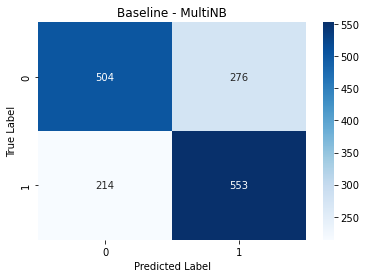

In [37]:
plot_confusion(model_name)

In [38]:
score_df = score_df.append(update_score_df(model_name), ignore_index=True)
score_df

,Name,Accuracy,Recall,Precision,F1
0,Baseline - MultiNB,0.683258,0.720991,0.667069,0.692982


#### Understanding the Confusion Matrix
The confusion matrix above shows our model's predictions when compared to the test data, which did not inform the way it was trained before those predictions. We can see on the bottom right that it __correctly predicted that an entry was labeled 'is_depression=1' 553 times (553 True Positives)__. We can also see that it predicted __'is_depression=0' correctly 504 times (504 True Negatives)__.

The model's recall score is influenced by the __214 incorrect predictions of 'is_depression=0', when it should have predicted 'is_depression=1'__. This is the number we hope to reduce in future models while also increasing the True Positives and True Negatives.

### Understanding Scoring
The score when predicting on test data, at __68.3% Accuracy__, is much closer to the 50% that random guessing would attain. Before diving too deep into this, though, we'll try using the _same model_ but with the _preprocessed data_:

## Baseline Model with Preprocessed Data

Now, instead of df['clean_text'], as our dataset, which contains all of the words unchanged by the preprocessing steps, we will use df['rejoined'], which contains __the data that has had stop words removed, and been lemmatized and rejoined__. Common knowledge says that we usually want to use the preprocessed dataset, but it's important to test the full data to be sure.

In [39]:
#model name for score keeping
model_name = 'Baseline - Preprocessed Data'

X = df['rejoined']
y = df['is_depression']

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

#### Pipelines

From this point on the analysis will use __pipelines__, which in this case will _vectorize the data in the same process as applying it to the classifier_ and in future models will also _help to fine tune the parameters of each model to produce optimal results_.

In [40]:
#create pipeline
pipe = Pipeline([('vectorizer', TfidfVectorizer(max_features=100)),
                          ('clf', MultinomialNB())
                         ])

#fit to data
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=100)),
                ('clf', MultinomialNB())])

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       780
           1       0.81      0.87      0.84       767

    accuracy                           0.83      1547
   macro avg       0.83      0.83      0.83      1547
weighted avg       0.84      0.83      0.83      1547



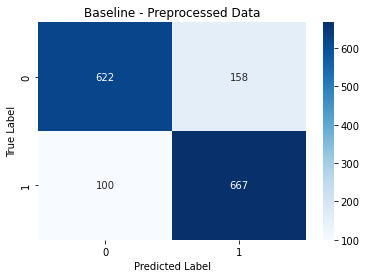

In [41]:
#predict on test data
y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))

plot_confusion(model_name)

In [42]:
score_df = score_df.append(update_score_df(model_name), ignore_index=True)
score_df

,Name,Accuracy,Recall,Precision,F1
0,Baseline - MultiNB,0.683258,0.720991,0.667069,0.692982
1,Baseline - Preprocessed Data,0.833226,0.869622,0.808485,0.837940


The model with preprocessed data shows a _vast improvement_ over the previous one. It's pretty clear that in this instance, our models can attain much stronger accuracy scores without all the stopwords adding noise to the data.

### Problematic Data?

##### ______________________________________ link to here from top

__However__, we also need to look at another potentially problematic sitaution. The purpose of the current analysis is to __prove that there is potential to look at an individual's written posts and determine whether or not they could be diagnosed with depression__. 

The current dataset, as per our earlier exploration contains a large amount of words such as "depression" and "anxiety" in the posts marked as depression. This _functionally means that our model could be "cheating"_, by just looking for words like "depression" to identify whether people are depressed. This __does not help us__, as we don't want the model to be dependent on self-declarations of depression, but rather to identify traits i the writing style of individuals who have not been diagnosed.

To verify this, we will look at the strongest coefficients in the current model:

In [43]:
coefficient_df = pd.DataFrame()
coefficient_df['feature'] = pipe['vectorizer'].get_feature_names()
coefficient_df['coefficients'] = pipe['clf'].coef_.T

#sort in descending order, to see which coefficient most affects the positive class prediction
coefficient_df.sort_values(by='coefficients', ascending=False)[:20]

C:\Users\shade\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


,feature,coefficients
15,depression,-2.928570
50,like,-3.506931
26,feel,-3.575731
2,anxiety,-3.714187
47,know,-3.889332
91,want,-3.892280
49,life,-3.899135
33,get,-3.937124
65,people,-4.037960
85,time,-4.053519


As expected, the strongest coefficient is "depression." The next steps come down to some __subjective decision making__. In order to investigate what sort of scores our model achieves without a few specific words. 

In this case, we're going to remove: __depression, feel, and anxiety__. There are some other words at the top of the coefficients list, like _like, know, and want_, but I'm hesitant to remove these because they are words that are very likely to be in sentences that don't have to do with feelings of depression. Again, this is _subjective_, and deserves further exploration and understanding in the future.

In [44]:
#same as stopword removal but our own list
def remove_some_words(data):
    words = ['depression', 'feel', 'anxiety']
    return [word for word in data if word not in words]

#remove words from lemmatized dataset without stopwords
df['subjective_removal'] = df.apply(lambda x: remove_some_words(x['lemmatized_no_stops']), axis=1)

In [45]:
#rejoin again for vectorizer!
df['rejoined_post_removal']= df.apply(lambda x: rejoin_words(x['subjective_removal']), axis=1)

## Baseline with Subjective Alterations

              precision    recall  f1-score   support

           0       0.74      0.76      0.75       780
           1       0.75      0.73      0.74       767

    accuracy                           0.74      1547
   macro avg       0.74      0.74      0.74      1547
weighted avg       0.74      0.74      0.74      1547



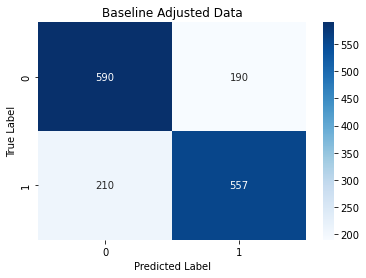

In [46]:
#model name for score keeping
model_name = 'Baseline Adjusted Data'

#repeat pipeline with new data
X = df['rejoined_post_removal']
y = df['is_depression']

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

#create pipeline
pipe = Pipeline([('vectorizer', TfidfVectorizer(max_features=100)),
                          ('clf', MultinomialNB())
                         ])

#fit to data
pipe.fit(X_train, y_train)

#predict on test data
y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))

plot_confusion(model_name)

In [47]:
score_df = score_df.append(update_score_df(model_name), ignore_index=True)
score_df

,Name,Accuracy,Recall,Precision,F1
0,Baseline - MultiNB,0.683258,0.720991,0.667069,0.692982
1,Baseline - Preprocessed Data,0.833226,0.869622,0.808485,0.837940
2,Baseline Adjusted Data,0.741435,0.726206,0.745649,0.735799


The score going down a bit __makes sense__, as we have removed some of the dead giveaway words from the dataset. Because of this, we'll go ahead and __keep using this version of the dataset for future models__. 

In [48]:
#check for problematic words in current model coefficients

coefficient_df = pd.DataFrame()
coefficient_df['feature'] = pipe['vectorizer'].get_feature_names()
coefficient_df['coefficients'] = pipe['clf'].coef_.T

#sort in descending order, to see which coefficient most affects the positive class prediction
coefficient_df.sort_values(by='coefficients', ascending=False)[:10]

C:\Users\shade\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


,feature,coefficients
48,like,-3.397138
45,know,-3.797430
91,want,-3.810001
47,life,-3.811550
30,get,-3.832728
63,people,-3.925495
85,time,-3.961266
18,even,-4.037119
62,one,-4.069629
13,day,-4.114895


## Model 2 - MultinomialNB (Tuned)

Next we'll run the data through MultinomialNB one more time, but this time using _GridSearchCV_ to select optimal parameters for our model. Additionally, we'll use the same process to select ideal parameters of our tf-idf Vectorizer in the process.

The scoring metric for these gridsearches will be __Recall__, in order to prevent the models from causing the misdiagnoses discussed earlier.


##### ____________________link to end of modeling

In [49]:
#example with tfidf:

#TfidfVectorizer:
tfidf_params = {
    'vectorizer__max_df': (0.25, 0.5, 0.75, 1.0),
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer__max_features': (None, 50, 100, 200, 300)
}

In [50]:
#model name for score keeping
model_name = 'Tuned MNB'

#parameters:
model_params = {
    'clf__alpha': (1e-3, 1e-2, 1e-1, 1)
}

#create pipeline
pipe = Pipeline([('vectorizer', TfidfVectorizer()),
                          ('clf', MultinomialNB())])

############################################################################################

params = [tfidf_params, model_params]

#gridsearch
gscv = GridSearchCV(pipe, params, cv = 5, n_jobs=-1, verbose=True, scoring = 'recall')
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'vectorizer__max_df': (0.25, 0.5, 0.75, 1.0),
                          'vectorizer__max_features': (None, 50, 100, 200, 300),
                          'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]},
                         {'clf__alpha': (0.001, 0.01, 0.1, 1)}],
             scoring='recall', verbose=True)

In [51]:
#see what hyperparameters were selected for best score
gscv.best_params_

{'vectorizer__max_df': 0.25,
 'vectorizer__max_features': None,
 'vectorizer__ngram_range': (1, 2)}

              precision    recall  f1-score   support

           0       0.98      0.48      0.65       780
           1       0.65      0.99      0.79       767

    accuracy                           0.74      1547
   macro avg       0.82      0.74      0.72      1547
weighted avg       0.82      0.74      0.72      1547



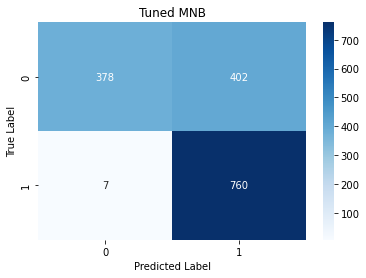

In [52]:
#predict on test data
y_pred = gscv.predict(X_test)

print(classification_report(y_test, y_pred))

plot_confusion(model_name)

In [53]:
score_df = score_df.append(update_score_df(model_name), ignore_index=True)
score_df

,Name,Accuracy,Recall,Precision,F1
0,Baseline - MultiNB,0.683258,0.720991,0.667069,0.692982
1,Baseline - Preprocessed Data,0.833226,0.869622,0.808485,0.837940
2,Baseline Adjusted Data,0.741435,0.726206,0.745649,0.735799
3,Tuned MNB,0.735617,0.990874,0.654045,0.787973


Here is a good example of where setting the scoring metric to "recall" can have side effects. Our model was trained to optimize recall, which leads to it __drastically reducing its accuracy score__.

We'll try it again with the scoring metric set to "accuracy" instead.

In [54]:
#model name for score keeping
model_name = 'Tuned MNB - Acc'

#parameters:
model_params = {
    'clf__alpha': (1e-3, 1e-2, 1e-1, 1)
}

#create pipeline
pipe = Pipeline([('vectorizer', TfidfVectorizer()),
                          ('clf', MultinomialNB())])

############################################################################################

params = [tfidf_params, model_params]

#gridsearch
gscv = GridSearchCV(pipe, params, cv = 5, n_jobs=-1, verbose=True, scoring = 'accuracy')
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'vectorizer__max_df': (0.25, 0.5, 0.75, 1.0),
                          'vectorizer__max_features': (None, 50, 100, 200, 300),
                          'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]},
                         {'clf__alpha': (0.001, 0.01, 0.1, 1)}],
             scoring='accuracy', verbose=True)

In [55]:
#see what hyperparameters were selected for best score
gscv.best_params_

{'clf__alpha': 0.1}

              precision    recall  f1-score   support

           0       0.96      0.77      0.85       780
           1       0.80      0.96      0.88       767

    accuracy                           0.86      1547
   macro avg       0.88      0.87      0.86      1547
weighted avg       0.88      0.86      0.86      1547



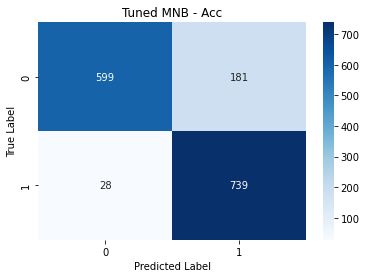

In [56]:
#predict on test data
y_pred = gscv.predict(X_test)

print(classification_report(y_test, y_pred))

plot_confusion(model_name)

In [57]:
score_df = score_df.append(update_score_df(model_name), ignore_index=True)
score_df

,Name,Accuracy,Recall,Precision,F1
0,Baseline - MultiNB,0.683258,0.720991,0.667069,0.692982
1,Baseline - Preprocessed Data,0.833226,0.869622,0.808485,0.837940
2,Baseline Adjusted Data,0.741435,0.726206,0.745649,0.735799
3,Tuned MNB,0.735617,0.990874,0.654045,0.787973
4,Tuned MNB - Acc,0.864900,0.963494,0.803261,0.876111


There is a __notable improvement in accuracy score__, compared to all previous models. But of course, this caused the model to take a hit to its __recall score__. 

Next we will run the data through 4 more models __(Logistic Regression, Decision Tree, Random Forest, and Support Vector Classification)__:

## Model 3 - Logistic Regression

In [58]:
#model name for score keeping
model_name = 'LogReg'

#parameters:
model_params = {
    'clf__C': np.logspace(-2, 2, 10),
    'clf__penalty': ['l1', 'l2']
}

#create pipeline
pipe = Pipeline([('vectorizer', TfidfVectorizer()),
                          ('clf', LogisticRegression(max_iter = 1000, random_state=42))])

############################################################################################

params = [tfidf_params, model_params]

#gridsearch
gscv = GridSearchCV(pipe, params, cv = 5, n_jobs=-1, verbose=True, scoring = 'recall')
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


C:\Users\shade\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.85574534 0.88511712 0.9066575  0.75130666 0.75130666 0.75130666
 0.76534135 0.76599388 0.76534135 0.81298447 0.81233247 0.8133118
 0.82408758 0.82604676 0.82604676 0.85574534 0.88511712 0.9066575
 0.75130666 0.75130666 0.75130666 0.76534135 0.76599388 0.76534135
 0.81298447 0.81233247 0.8133118  0.82408758 0.82604676 0.82604676
 0.85574534 0.88511712 0.9066575  0.75130666 0.75130666 0.75130666
 0.76534135 0.76599388 0.76534135 0.81298447 0.81233247 0.8133118
 0.82408758 0.82604676 0.82604676 0.85574534 0.88511712 0.9066575
 0.75130666 0.75130666 0.75130666 0.76534135 0.76599388 0.76534135
 0.81298447 0.81233247 0.8133118  0.82408758 0.82604676 0.82604676
        nan 0.69223363        nan 0.72389353        nan 0.75685528
        nan 0.80352867        nan 0.8436709         nan 0.86814499
        nan 0.88282901        nan 0.88837763        nan 0

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid=[{'vectorizer__max_df': (0.25, 0.5, 0.75, 1.0),
                          'vectorizer__max_features': (None, 50, 100, 200, 300),
                          'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]},
                         {'clf__C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02]),
                          'clf__penalty': ['l1', 'l2']}],
             scoring='recall', verbose=True)

In [59]:
#see what hyperparameters were selected for best score
gscv.best_params_

{'vectorizer__max_df': 0.25,
 'vectorizer__max_features': None,
 'vectorizer__ngram_range': (1, 3)}

              precision    recall  f1-score   support

           0       0.91      0.83      0.87       780
           1       0.84      0.92      0.88       767

    accuracy                           0.87      1547
   macro avg       0.87      0.87      0.87      1547
weighted avg       0.87      0.87      0.87      1547



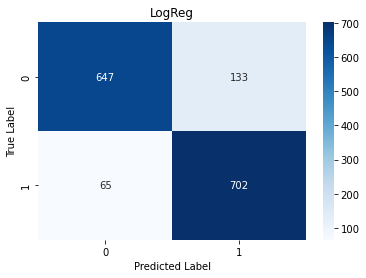

In [60]:
#predict on test data
y_pred = gscv.predict(X_test)

print(classification_report(y_test, y_pred))

plot_confusion(model_name)

In [61]:
score_df = score_df.append(update_score_df(model_name), ignore_index=True)
score_df

,Name,Accuracy,Recall,Precision,F1
0,Baseline - MultiNB,0.683258,0.720991,0.667069,0.692982
1,Baseline - Preprocessed Data,0.833226,0.869622,0.808485,0.837940
2,Baseline Adjusted Data,0.741435,0.726206,0.745649,0.735799
3,Tuned MNB,0.735617,0.990874,0.654045,0.787973
4,Tuned MNB - Acc,0.864900,0.963494,0.803261,0.876111
5,LogReg,0.872010,0.915254,0.840719,0.876404


This model shows much __stronger accuracy, but weaker Recall__ than the previous. This can be seen easily by the 65 False Negatives compared to the MNB model's 7. It does have the highest Accuracy score by far, though, so is still in the running.

## Model 4 - Decision Tree

In [62]:
#model name for score keeping
model_name = 'Decision Tree'

#parameters:
model_params = {
    'clf__max_depth': [2, 3, 5, 10, 20],
    'clf__min_samples_leaf': [5, 10, 20, 50, 100],
    'clf__criterion': ["gini", "entropy"]
}

#create pipeline
pipe = Pipeline([('vectorizer', TfidfVectorizer()),
                          ('clf', DecisionTreeClassifier(random_state=42))])

############################################################################################

params = [tfidf_params, model_params]

#gridsearch
gscv = GridSearchCV(pipe, params, cv = 5, n_jobs=-1, verbose=True, scoring = 'recall')
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 110 candidates, totalling 550 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('clf',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'vectorizer__max_df': (0.25, 0.5, 0.75, 1.0),
                          'vectorizer__max_features': (None, 50, 100, 200, 300),
                          'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]},
                         {'clf__criterion': ['gini', 'entropy'],
                          'clf__max_depth': [2, 3, 5, 10, 20],
                          'clf__min_samples_leaf': [5, 10, 20, 50, 100]}],
             scoring='recall', verbose=True)

In [63]:
#see what hyperparameters were selected for best score
gscv.best_params_

{'vectorizer__max_df': 0.25,
 'vectorizer__max_features': None,
 'vectorizer__ngram_range': (1, 1)}

              precision    recall  f1-score   support

           0       0.84      0.80      0.82       780
           1       0.81      0.85      0.83       767

    accuracy                           0.82      1547
   macro avg       0.83      0.82      0.82      1547
weighted avg       0.83      0.82      0.82      1547



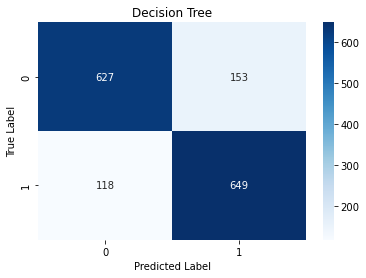

In [64]:
#predict on test data
y_pred = gscv.predict(X_test)

print(classification_report(y_test, y_pred))

plot_confusion(model_name)

In [65]:
score_df = score_df.append(update_score_df(model_name), ignore_index=True)
score_df

,Name,Accuracy,Recall,Precision,F1
0,Baseline - MultiNB,0.683258,0.720991,0.667069,0.692982
1,Baseline - Preprocessed Data,0.833226,0.869622,0.808485,0.837940
2,Baseline Adjusted Data,0.741435,0.726206,0.745649,0.735799
3,Tuned MNB,0.735617,0.990874,0.654045,0.787973
4,Tuned MNB - Acc,0.864900,0.963494,0.803261,0.876111
5,LogReg,0.872010,0.915254,0.840719,0.876404
6,Decision Tree,0.824822,0.846154,0.809227,0.827279


Unfortunately, both the confusion matrix and score dataframe show that the Decision Tree Classifier is __not optimal for this analysis__.

## Model 5 - Random Forest

In [66]:
#model name for score keeping
model_name = 'Random Forest'

#parameters:
model_params = {
    'clf__n_estimators': [10,100,1000],
    'clf__max_depth': [None, 3, 4, 10],
    'clf__max_features': [2, 5, 10]
    
}

#create pipeline
pipe = Pipeline([('vectorizer', TfidfVectorizer()),
                          ('clf', RandomForestClassifier(random_state=42))])

############################################################################################

params = [tfidf_params, model_params]

#gridsearch
gscv = GridSearchCV(pipe, params, cv = 5, n_jobs=-1, verbose=True, scoring = 'recall')
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'vectorizer__max_df': (0.25, 0.5, 0.75, 1.0),
                          'vectorizer__max_features': (None, 50, 100, 200, 300),
                          'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]},
                         {'clf__max_depth': [None, 3, 4, 10],
                          'clf__max_features': [2, 5, 10],
                          'clf__n_estimators': [10, 100, 1000]}],
             scoring='recall', verbose=True)

In [67]:
#see what hyperparameters were selected for best score
gscv.best_params_

{'vectorizer__max_df': 0.25,
 'vectorizer__max_features': None,
 'vectorizer__ngram_range': (1, 1)}

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       780
           1       0.89      0.86      0.87       767

    accuracy                           0.88      1547
   macro avg       0.88      0.88      0.88      1547
weighted avg       0.88      0.88      0.88      1547



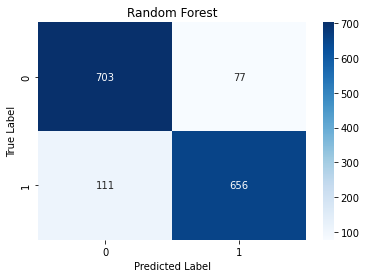

In [68]:
#predict on test data
y_pred = gscv.predict(X_test)

print(classification_report(y_test, y_pred))

plot_confusion(model_name)

In [69]:
score_df = score_df.append(update_score_df(model_name), ignore_index=True)
score_df

,Name,Accuracy,Recall,Precision,F1
0,Baseline - MultiNB,0.683258,0.720991,0.667069,0.692982
1,Baseline - Preprocessed Data,0.833226,0.869622,0.808485,0.837940
2,Baseline Adjusted Data,0.741435,0.726206,0.745649,0.735799
3,Tuned MNB,0.735617,0.990874,0.654045,0.787973
4,Tuned MNB - Acc,0.864900,0.963494,0.803261,0.876111
5,LogReg,0.872010,0.915254,0.840719,0.876404
6,Decision Tree,0.824822,0.846154,0.809227,0.827279
7,Random Forest,0.878474,0.855280,0.894952,0.874667


Much like the Logistic Regression Model, the Random Forest Classifier has shown an __increase in accuracy with a decrease in recall__ when compared to the previous strongest model. This still puts it in the running, but will need to be investigated further after all modeling is complete.

## Model 6 - Support Vector Classification

In [70]:
#model name for score keeping
model_name = 'SVC'

#create pipeline
pipe = Pipeline([('vectorizer', TfidfVectorizer()),
                          ('clf', LinearSVC())])

############################################################################################

params = [tfidf_params]

#gridsearch
gscv = GridSearchCV(pipe, params, cv = 5, n_jobs=-1, verbose=True, scoring = 'recall')
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('clf', LinearSVC())]),
             n_jobs=-1,
             param_grid=[{'vectorizer__max_df': (0.25, 0.5, 0.75, 1.0),
                          'vectorizer__max_features': (None, 50, 100, 200, 300),
                          'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]}],
             scoring='recall', verbose=True)

              precision    recall  f1-score   support

           0       0.93      0.85      0.89       780
           1       0.86      0.94      0.90       767

    accuracy                           0.89      1547
   macro avg       0.90      0.89      0.89      1547
weighted avg       0.90      0.89      0.89      1547



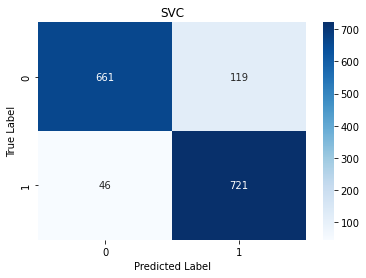

In [71]:
#predict on test data
y_pred = gscv.predict(X_test)

print(classification_report(y_test, y_pred))

plot_confusion(model_name)

In [72]:
score_df = score_df.append(update_score_df(model_name), ignore_index=True)
score_df

,Name,Accuracy,Recall,Precision,F1
0,Baseline - MultiNB,0.683258,0.720991,0.667069,0.692982
1,Baseline - Preprocessed Data,0.833226,0.869622,0.808485,0.837940
2,Baseline Adjusted Data,0.741435,0.726206,0.745649,0.735799
3,Tuned MNB,0.735617,0.990874,0.654045,0.787973
4,Tuned MNB - Acc,0.864900,0.963494,0.803261,0.876111
5,LogReg,0.872010,0.915254,0.840719,0.876404
6,Decision Tree,0.824822,0.846154,0.809227,0.827279
7,Random Forest,0.878474,0.855280,0.894952,0.874667
8,SVC,0.893342,0.940026,0.858333,0.897324


The SVC Classifier continued to __increase accuracy__, and also managed to __increase recall score to almost same level as the Tuned MNB Model__. Further discussion of comparative notes below:

## Strongest Model Analysis

##### ______________________________________ link to here from top

First we'll look at the score dataframe, but excluding the first two models on it since they used different datasets than the others:

In [73]:
#compare models all using same dataset:
score_df.drop([0,1], axis=0).sort_values(by=['Accuracy'], ascending=False).style.hide_index()

Name,Accuracy,Recall,Precision,F1
SVC,0.893342,0.940026,0.858333,0.897324
Random Forest,0.878474,0.855280,0.894952,0.874667
LogReg,0.872010,0.915254,0.840719,0.876404
Tuned MNB - Acc,0.864900,0.963494,0.803261,0.876111
Decision Tree,0.824822,0.846154,0.809227,0.827279
Baseline Adjusted Data,0.741435,0.726206,0.745649,0.735799
Tuned MNB,0.735617,0.990874,0.654045,0.787973


Now as a refresher, we'll look at the top 3 models' confusion matrices:

Text(0.5, 1.0, 'Acc: 87.8%            ')

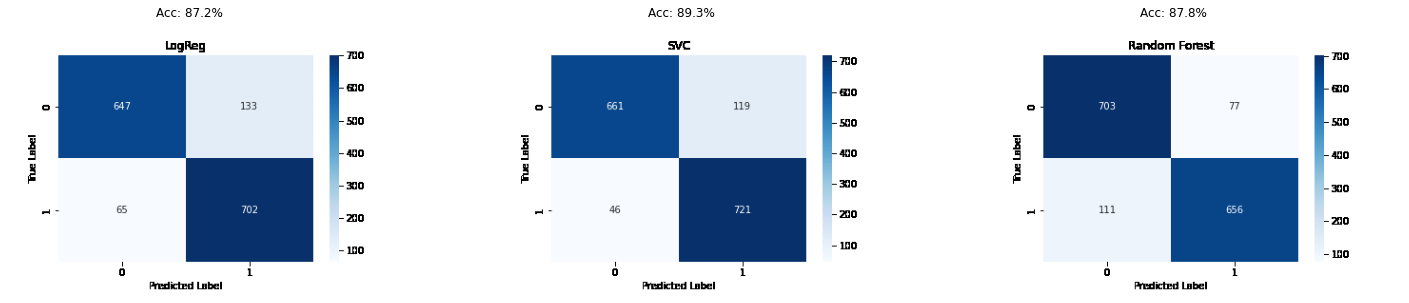

In [109]:
# show top 3 confusion:


# create figure
fig = plt.figure(figsize=(25, 10))
  
# setting values to rows and column variables
rows = 1
columns = 3
  
# reading images
Image1 = cv2.imread('./img/LogReg.png')
RGB_img1 = cv2.cvtColor(Image1, cv2.COLOR_BGR2RGB)
Image2 = cv2.imread('./img/SVC.png')
RGB_img2 = cv2.cvtColor(Image2, cv2.COLOR_BGR2RGB)
Image3 = cv2.imread('./img/Random Forest.png')
RGB_img3 = cv2.cvtColor(Image3, cv2.COLOR_BGR2RGB)
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(RGB_img1)
plt.axis('off')
plt.title("Acc: 87.2%            ")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(RGB_img2)
plt.axis('off')
plt.title("Acc: 89.3%            ")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(RGB_img3)
plt.axis('off')
plt.title("Acc: 87.8%            ")

The __SVC Model easily outperforms the others__, as it scores higher in both __accuracy and recall__, shown clearly by its confusion matrix as well.

For investigative purposes we'll look at the strongest coefficients for this model:

In [ ]:
# X = df['rejoined_post_removal']
# y = df['is_depression']
# #train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

#remake LogReg model with best parameters from earlier gridsearch
pipe = Pipeline([('vectorizer', TfidfVectorizer(max_features=100)),
                          ('clf', LinearSVC())
                         ])

#fit to data
pipe.fit(X_train, y_train)

In [76]:
coefficient_df = pd.DataFrame()
coefficient_df['feature'] = pipe['vectorizer'].get_feature_names()
coefficient_df['coefficients'] = pipe['clf'].coef_.T

#sort in descending order, to see which coefficient most affects the positive class prediction
coefficient_df.sort_values(by='coefficients', ascending=False)[:15]

,feature,coefficients
14,die,1.505974
55,month,1.369141
29,fucking,1.362365
3,anyone,1.281926
47,life,1.258720
40,help,1.250503
25,felt,1.247294
10,care,1.166338
0,also,1.155204
63,people,1.064181


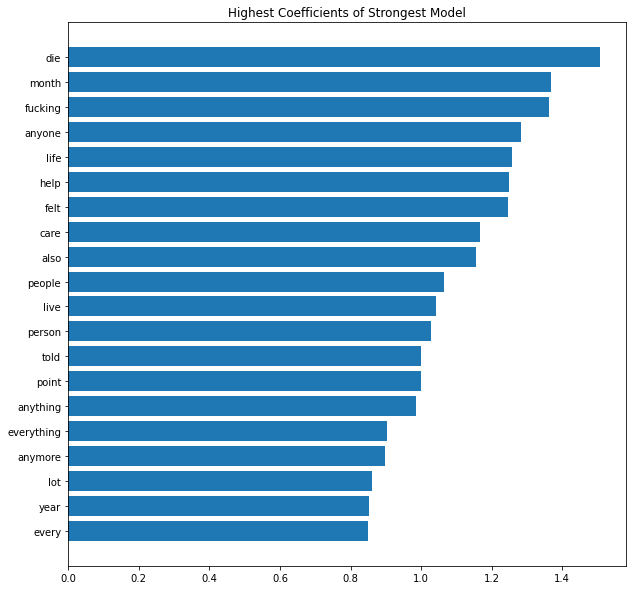

<Figure size 432x288 with 0 Axes>

In [77]:
coefs = coefficient_df.sort_values(by='coefficients', ascending=False)[:20]

fig = plt.figure(figsize =(10, 10))
plt.gca().invert_yaxis()
plt.barh(coefs['feature'], coefs['coefficients'])
plt.title('Highest Coefficients of Strongest Model')

# Show Plot
plt.show()

figname='coef-FinalModel'
plt.savefig('./img/'+figname+'.png')

There are a few words in these top 20 coefficients that should not come as a surprise, like _die_ and _fucking_. It's also interesting to note that the words _anything, everything,_ and _anymore_ are strong coefficients. Perhaps people in the depressed category are more likely to speak in absolutes.

We can also look at what this model identifies as the strongest coefficients in the un-altered, 'clean_text' dataset, with the words we removed at the start of modeling:

In [78]:
X = df['rejoined']
y = df['is_depression']
#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

#remake LogReg model with best parameters from earlier gridsearch
pipe = Pipeline([('vectorizer', TfidfVectorizer(max_features=100)),
                          ('clf', LinearSVC())
                         ])

#fit to data
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=100)),
                ('clf', LinearSVC())])

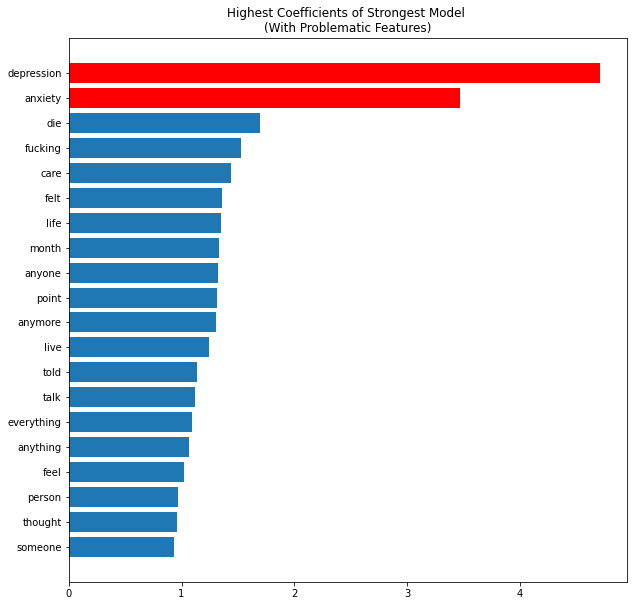

<Figure size 432x288 with 0 Axes>

In [79]:
coefficient_df = pd.DataFrame()
coefficient_df['feature'] = pipe['vectorizer'].get_feature_names()
coefficient_df['coefficients'] = pipe['clf'].coef_.T

coefs = coefficient_df.sort_values(by='coefficients', ascending=False)[:20]

###########################################################
problem_colors = ['#1f77b4' if (x < 3) else 'red' for x in coefs['coefficients'] ]

fig = plt.figure(figsize =(10, 10))
plt.gca().invert_yaxis()
plt.barh(coefs['feature'], coefs['coefficients'], color = problem_colors)
plt.title('Highest Coefficients of Strongest Model \n(With Problematic Features)')

# Show Plot
plt.show()

figname='coef-FinalModel-withProblematic'
plt.savefig('./img/'+figname+'.png')

As expected, the words _depression_ and _anxiety_ greatly outweigh the other coefficients. This shows it was a good idea to remove these words from the corpus, and also shows that our models are decently wll trained to have scored to high without these words involved.

## Next Steps

Technically, these findings already lend credence to the objctives of the analysis. We can see that there is reason to further explore the correlation between an individual's writing style and their potential to be diagnosable with depression, _especially_ if it were possible to train models on a more detailed dataset. More on this in the conclusion of the analysis.

##### link to end ________________________________________

__However__, so far our modeling has only ever been identifying _individual tokens_ within the corpus that may lead to identifying these outcomes. Natural Language Processing can do far more than this, though. For example, we can look at the prominence of __Bigrams__ (pairings of words) within the 'is_depressed=1' data:

### Bigrams

In [114]:
#collect all words in corpus in depressed class into one list
all_words_dep = sum(depressed_df['tokenized_no_stops'], [])

In [115]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
bi_finder_dep = BigramCollocationFinder.from_words(all_words_dep)
bi_scored_dep = bi_finder_dep.score_ngrams(bigram_measures.raw_freq)
bi_scored_dep[:20]

[(('feel', 'like'), 0.005140556008753188),
 (('gon', 'na'), 0.0009970347926297116),
 (('http', 'co'), 0.0009366084415612443),
 (('mental', 'health'), 0.0009107114339604725),
 (('wan', 'na'), 0.0009063952660270106),
 (('panic', 'attack'), 0.0008934467622266247),
 (('even', 'though'), 0.000677638365553527),
 (('make', 'feel'), 0.000677638365553527),
 (('anyone', 'else'), 0.0006646898617531411),
 (('every', 'day'), 0.0006517413579527553),
 (('year', 'old'), 0.0006387928541523694),
 (('get', 'better'), 0.0006344766862189074),
 (('year', 'ago'), 0.0005567856634165922),
 (('felt', 'like'), 0.0005524694954831302),
 (('last', 'year'), 0.0005438371596162064),
 (('depression', 'anxiety'), 0.0005308886558158205),
 (('want', 'die'), 0.0005093078161485107),
 (('anxiety', 'depression'), 0.0004877269764812009),
 (('every', 'time'), 0.0004877269764812009),
 (('best', 'friend'), 0.0004704623047473531)]

With a little bit of data cleaning we can remove the "words" that are making this data hard to interpret:

In [116]:
remove_words = ['na', 'http', 'com', 'ta']
all_words_dep = [word for word in all_words_dep if word not in remove_words]

In [117]:
bi_finder_dep = BigramCollocationFinder.from_words(all_words_dep)
bi_scored_dep = bi_finder_dep.score_ngrams(bigram_measures.raw_freq)
bi_scored_dep[:20]

[(('feel', 'like'), 0.005157786698886594),
 (('mental', 'health'), 0.0009137640583249968),
 (('panic', 'attack'), 0.0008964415169349495),
 (('even', 'though'), 0.0006799097495593579),
 (('make', 'feel'), 0.0006799097495593579),
 (('anyone', 'else'), 0.0006669178435168223),
 (('every', 'day'), 0.0006539259374742869),
 (('year', 'old'), 0.0006409340314317513),
 (('get', 'better'), 0.0006366033960842395),
 (('year', 'ago'), 0.0005586519598290265),
 (('felt', 'like'), 0.0005543213244815147),
 (('last', 'year'), 0.000545660053786491),
 (('depression', 'anxiety'), 0.0005326681477439556),
 (('want', 'die'), 0.0005110149710063963),
 (('anxiety', 'depression'), 0.0004893617942688372),
 (('every', 'time'), 0.0004893617942688372),
 (('best', 'friend'), 0.00047203925287878985),
 (('wish', 'could'), 0.0004633779821837662),
 (('first', 'time'), 0.00045904734683625435),
 (('high', 'school'), 0.00042007162870864786)]

__Looks like__ the depressed class has a heavy prominence of the bigrams _feel like_, _mental health_, and _panic attack_. Some of this seems understandable, but a deeper investigation could also show some unexpected results.

Let's look at the 'non-depressed' class:

In [118]:
all_words_undiag = sum(undiag_df['tokenized_no_stops'], [])
all_words_undiag = [word for word in all_words_undiag if word not in remove_words]

In [119]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
bi_finder_undiag = BigramCollocationFinder.from_words(all_words_undiag)
bi_scored_undiag = bi_finder_undiag.score_ngrams(bigram_measures.raw_freq)
bi_scored_undiag[:15]

[(('last', 'night'), 0.0013673959445037354),
 (('feel', 'like'), 0.001200640341515475),
 (('sorry', 'hear'), 0.0007670757737459978),
 (('want', 'go'), 0.0007003735325506937),
 (('wish', 'could'), 0.0006003201707577375),
 (('wan', 'go'), 0.0005336179295624333),
 (('cant', 'sleep'), 0.0005002668089647812),
 (('kal', 'penn'), 0.0005002668089647812),
 (('look', 'like'), 0.0005002668089647812),
 (('looking', 'forward'), 0.0005002668089647812),
 (('come', 'back'), 0.0004669156883671291),
 (('go', 'work'), 0.0004669156883671291),
 (('good', 'morning'), 0.0004669156883671291),
 (('back', 'work'), 0.00043356456776947705),
 (('go', 'back'), 0.00043356456776947705)]

There is a clear difference in the words prominent in this class, and a whole additional analysis could attempt to investigate which bigrams (or trigrams, or any n-grams) tend to be the strongest predictors of depression, or other mental illnesses.

#### Visualization of Depressed Class Bigrams:

In [87]:
bi_scored_dep_viz = pd.Series(dict(bi_scored_dep))[:15]

In [110]:
#change tuple bigram format into easy-to-plot array
indices = []
for x in bi_scored_dep_viz.index:
    indices.append(x[0]+ " "+x[1])

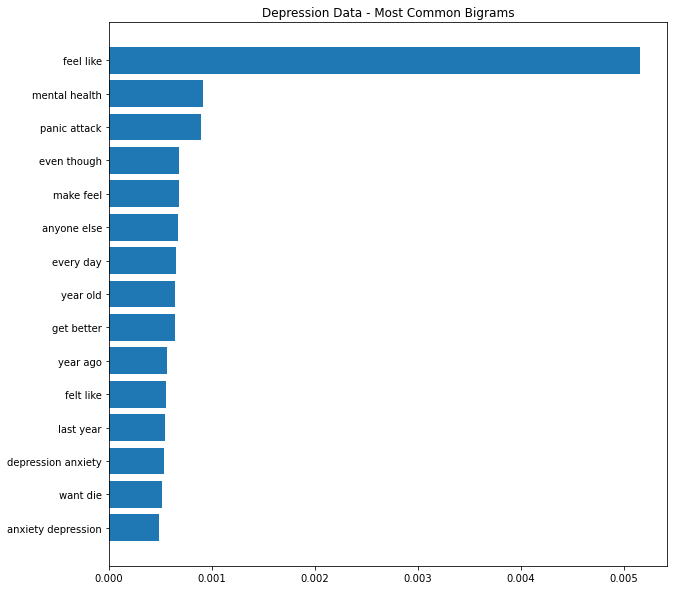

<Figure size 432x288 with 0 Axes>

In [111]:
fig = plt.figure(figsize =(10, 10))
plt.gca().invert_yaxis()
plt.barh(indices, bi_scored_dep_viz.values)
plt.title('Depression Data - Most Common Bigrams')

# Show Plot
plt.show()

figname='Depression_Bigrams'
plt.savefig('./img/'+figname+'.png')

# Word Embeddings

Another way to investigate relationships in the corpus is through _Word Embeddings_, which refers to the process of _creating Word Vector Embeddings that capture a word's semantic data in relationship to other words_, rather than just looking at an individual word's appearances in the corpus.

## Word2Vec

We will be using a __Word2Vec Model__, which is a deep neural network that can

In this instance, we will be using the full, un-processed corpus, from df['clean_text'], so that the model can identify appropriate sentence structure and relationships.

In [130]:
model_name='W2V Model'

#create w2v model with tokenized full dataset
w2v_X=df['tokenized']
w2v_model = Word2Vec(w2v_X, vector_size=100, window=5, min_count=2)

#print(w2v_model.wv.index_to_key[:100])

In [132]:
#show model's most similar words
w2v_model.wv.most_similar('depression')

[('social', 0.7420157790184021),
 ('physical', 0.7138218283653259),
 ('mental', 0.6951000690460205),
 ('stress', 0.6894680261611938),
 ('health', 0.6840561628341675),
 ('trauma', 0.6790390610694885),
 ('severe', 0.670187771320343),
 ('ocd', 0.6652696132659912),
 ('adhd', 0.6633910536766052),
 ('medium', 0.6612170934677124)]

We can see that with just that small amount of effort, the Word2Vec model can easily identify relationships between different words! This is entirely from the words within our corpus, though, and it would be better if we used word relationships from a larger set of data.

Going forward, we'll use a set of _pre-trained weights_, from __GloVe (Global Vectors for Word Representation)__ from the Stanforf NLP Group. These weights are commonly accepted as some of the best pre-trained word vectors available. It contains vector information for _6 billion words_. We will use two different versions of GloVe for comparison: one with 50-dimensional word vectors and one with 100-dimensional word vectors.

In [92]:
#get total vocabulary of our data so that we only take words we need:

#tokenized data with all words
X=df['tokenized']
y=df['is_depression']

#split current data for modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

We only need the vector data for every word in our corpus, so we'll only bring in words from GloVe that are in our own data's vocabulary:

In [93]:
#get total vocabulary of entire training 
total_vocabulary = set(word for entry in X for word in entry)

#show total vocab:
print('There are {} unique tokens in the dataset.'.format(len(total_vocabulary)))

There are 18775 unique tokens in the dataset.


In [94]:
#search glove.6B.50d data for our own words:
glove50 = {}
with open('./data/glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove50[word] = vector
            
#same with 100d data
glove100 = {}
with open('./data/glove.6B.100d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove100[word] = vector

In [95]:
#show size of 50 dimensional vector for depression
glove50['depression']

array([ 0.81539 ,  0.31056 , -0.25971 , -1.2212  , -1.7488  ,  0.68802 ,
        0.39753 ,  0.17298 , -0.097186,  0.28354 ,  0.25045 ,  0.20969 ,
       -0.019338, -0.33467 , -0.038643, -0.011519, -1.6151  , -0.30461 ,
       -0.50434 ,  0.66403 , -0.67055 ,  0.15239 ,  0.52831 , -0.25426 ,
        0.50801 , -0.83183 , -0.43301 , -0.18163 ,  0.95466 ,  1.4164  ,
        2.313   ,  0.23765 ,  0.86228 , -1.2755  , -0.52824 , -0.15141 ,
       -0.50096 , -0.30892 ,  1.1232  , -0.32011 , -1.2358  , -0.19507 ,
        0.51594 ,  0.46977 ,  0.28115 ,  0.44771 ,  0.75517 , -1.2266  ,
       -0.010493,  0.5018  ], dtype=float32)

In [96]:
#show size of 100 dimensional vector for depression
glove100['depression']

array([ 0.10542  , -0.13691  ,  0.15946  ,  0.99195  , -1.1368   ,
        0.18614  ,  0.036245 , -0.6107   , -0.091113 , -0.52332  ,
        0.030946 , -0.35659  , -0.44533  , -0.12095  ,  1.7213   ,
       -0.27306  ,  0.502    , -0.45359  , -0.37612  , -0.36712  ,
        0.32663  ,  0.56371  , -0.58183  ,  0.39254  , -0.48831  ,
        0.4093   , -0.0067719, -1.1515   , -0.33624  ,  0.25515  ,
        0.48866  ,  0.47035  ,  0.046441 ,  0.042582 , -1.1799   ,
        0.19842  ,  0.57576  , -0.28609  , -0.090024 ,  0.61114  ,
       -0.8027   ,  0.097761 , -0.35865  , -0.29034  ,  0.76079  ,
        0.42944  ,  1.1057   ,  0.34321  ,  0.40805  , -0.47787  ,
       -0.63205  , -0.17783  ,  0.050688 ,  0.795    ,  0.84402  ,
       -1.5069   ,  0.51453  , -0.50486  ,  0.56217  ,  1.1522   ,
        0.24492  ,  1.8298   ,  0.33141  , -0.69176  ,  0.27301  ,
        0.629    , -0.015768 , -0.95589  ,  1.0203   , -0.54593  ,
       -0.28555  ,  0.099894 , -0.32071  ,  0.73616  , -0.0568

In [97]:
#example of glove pre-trained model's similar words:

def find_closest_embeddings(embedding):
    return sorted(glove50.keys(), key=lambda word: spatial.distance.euclidean(glove50[word], embedding))

find_closest_embeddings(glove50["depression"])[:10]

['depression',
 'onset',
 'alcoholism',
 'illness',
 'severe',
 'debilitating',
 'experiencing',
 'fever',
 'anxiety',
 'worsened']

We can see that, much like with our w2v model we made from scratch, there are several understandable words that GloVe has associated with the word 'depression'.

Next, we'll use the code below to create a__mean word embeddings vectorizer class__ which will make it possible for us to use this data in Machine Learning pipelines:

In [98]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove50))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

First let's use the GloVe vectors with our earlier highest-scoring model, _SVC_:

### Glove Model 1 - SVC

In [99]:
#model name for score keeping
model_name = 'Glove-50 SVC'

#remake LogReg model with best parameters from earlier gridsearch
pipe = Pipeline([('vectorizer', W2vVectorizer(glove50)),
                          ('clf', LinearSVC())
                         ])

#fit to data
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 <__main__.W2vVectorizer object at 0x0000021DE97C0760>),
                ('clf', LinearSVC())])

              precision    recall  f1-score   support

           0       0.86      0.79      0.82       780
           1       0.80      0.87      0.84       767

    accuracy                           0.83      1547
   macro avg       0.83      0.83      0.83      1547
weighted avg       0.83      0.83      0.83      1547



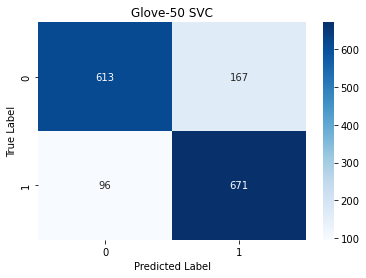

In [100]:
#predict on test data
y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))

plot_confusion(model_name)

At 83% accuracy and with so many False Positives and False Negatives, it's clear we need to determine a classifier to use with this data. Below is a streamlined attempt to identify which of our top 3 models from before perform strongest with the train data.

In [101]:
rf =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove50)),
              ('Random Forest', RandomForestClassifier(n_estimators=100, verbose=True))])
svc = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove50)),
                ('Support Vector Classifier', LinearSVC())])
lr = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove50)),
              ('Logistic Regression', LogisticRegression(max_iter = 1000))])

models = [('Random Forest', rf),
          ('Support Vector Machine', svc),
          ('Logistic Regression', lr)]

scores = [(name, cross_val_score(model, X_train, y_train, cv=2).mean()) for name, model, in models]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [102]:
scores

[('Random Forest', 0.901843467011643),
 ('Support Vector Machine', 0.8198576972833118),
 ('Logistic Regression', 0.8177554980595084)]

The best score was the Random Forest Classifier, so we'll go ahead with that:

### Glove Model 2 - Random Forest

In [103]:
#model name for score keeping
model_name = 'Glove-50 Random Forest'


params = {
    'clf__n_estimators': [10,100,1000],
    'clf__max_depth': [None, 3, 4, 10],
    'clf__max_features': [2, 5, 10]
    
}

#remake LogReg model with best parameters from earlier gridsearch
pipe = Pipeline([('vectorizer', W2vVectorizer(glove50)),
                          ('clf', RandomForestClassifier(random_state=42))
                         ])

#gridsearch
gscv = GridSearchCV(pipe, params, cv = 5, n_jobs=-1, verbose=True, scoring = 'recall')
gscv.fit(X_train, y_train)


#fit to data
pipe.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


Pipeline(steps=[('vectorizer',
                 <__main__.W2vVectorizer object at 0x0000021DE97C0B50>),
                ('clf', RandomForestClassifier(random_state=42))])

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       780
           1       0.95      0.85      0.90       767

    accuracy                           0.90      1547
   macro avg       0.91      0.90      0.90      1547
weighted avg       0.91      0.90      0.90      1547



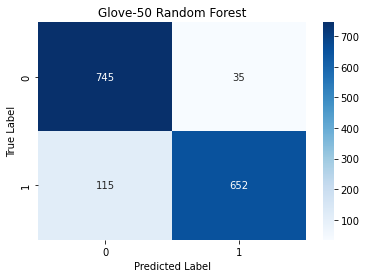

In [104]:
#predict on test data
y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))

plot_confusion(model_name)

In [105]:
score_df = score_df.append(update_score_df(model_name), ignore_index=True)
score_df

,Name,Accuracy,Recall,Precision,F1
0,Baseline - MultiNB,0.683258,0.720991,0.667069,0.692982
1,Baseline - Preprocessed Data,0.833226,0.869622,0.808485,0.837940
2,Baseline Adjusted Data,0.741435,0.726206,0.745649,0.735799
3,Tuned MNB,0.735617,0.990874,0.654045,0.787973
4,Tuned MNB - Acc,0.864900,0.963494,0.803261,0.876111
5,LogReg,0.872010,0.915254,0.840719,0.876404
6,Decision Tree,0.824822,0.846154,0.809227,0.827279
7,Random Forest,0.878474,0.855280,0.894952,0.874667
8,SVC,0.893342,0.940026,0.858333,0.897324
9,Glove-50 Random Forest,0.903038,0.850065,0.949054,0.896836


We can see that there is a very strong Accuracy and Recall score, albeit a lower recall than our best "individual words" model. We can try again with the 100-dimensional GloVe data:

In [106]:
#model name for score keeping
model_name = 'Glove-100 Random Forest'


params = {
    'clf__n_estimators': [10,100,1000],
    'clf__max_depth': [None, 3, 4, 10],
    'clf__max_features': [2, 5, 10]
    
}

#remake LogReg model with best parameters from earlier gridsearch
pipe = Pipeline([('vectorizer', W2vVectorizer(glove100)),
                          ('clf', RandomForestClassifier(random_state=42))
                         ])

#gridsearch
gscv = GridSearchCV(pipe, params, cv = 5, n_jobs=-1, verbose=True, scoring = 'recall')
gscv.fit(X_train, y_train)


#fit to data
pipe.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


Pipeline(steps=[('vectorizer',
                 <__main__.W2vVectorizer object at 0x0000021DE5714580>),
                ('clf', RandomForestClassifier(random_state=42))])

              precision    recall  f1-score   support

           0       0.88      0.97      0.93       780
           1       0.97      0.87      0.92       767

    accuracy                           0.92      1547
   macro avg       0.93      0.92      0.92      1547
weighted avg       0.93      0.92      0.92      1547



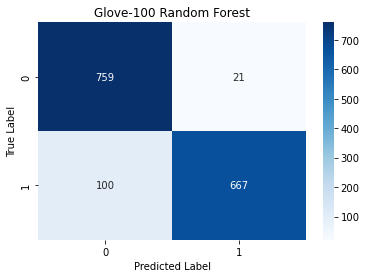

In [107]:
#predict on test data
y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))

plot_confusion(model_name)

In [120]:
score_df = score_df.append(update_score_df(model_name), ignore_index=True)

,Name,Accuracy,Recall,Precision,F1
0,Baseline - MultiNB,0.683258,0.720991,0.667069,0.692982
1,Baseline - Preprocessed Data,0.833226,0.869622,0.808485,0.837940
2,Baseline Adjusted Data,0.741435,0.726206,0.745649,0.735799
3,Tuned MNB,0.735617,0.990874,0.654045,0.787973
4,Tuned MNB - Acc,0.864900,0.963494,0.803261,0.876111
5,LogReg,0.872010,0.915254,0.840719,0.876404
6,Decision Tree,0.824822,0.846154,0.809227,0.827279
7,Random Forest,0.878474,0.855280,0.894952,0.874667
8,SVC,0.893342,0.940026,0.858333,0.897324
9,Glove-50 Random Forest,0.903038,0.850065,0.949054,0.896836


##### explain ________________________________

In [121]:
final_scores_df =score_df.loc[[8,10]]
final_scores_df

,Name,Accuracy,Recall,Precision,F1
8,SVC,0.893342,0.940026,0.858333,0.897324
10,Glove-100 Random Forest,0.921784,0.869622,0.969477,0.916838


The GloVe-100 vectors in combination with the Random Forest Classifier yield the best accuracy scores so far! Looking at the confusion matrix shows far more False Negatives, though, which is less than ideal.

All in all, though, this brief dip into Word Embeddings has only __further proved__ how valuable this kind of analysis could be if only we had the right data.

***
***

# Conclusion